## 1. Import libraries and data exploration

In [1]:
import os
import time
import h5py
import random
import math
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
random.seed(7)

In [2]:
# Check a list containing the names of the entries in the directory given by path

print(os.listdir("./input/train"))
print(os.listdir("./input/test"))

['images_training.h5', 'labels_training.h5']
['images_testing.h5', 'labels_testing_2000.h5']


In [3]:
# Load the train images and labels data and check the shape

with h5py.File('./input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

print(data_train.shape,label_train.shape) #30,000 images and each image has 784 features

(30000, 784) (30000,)


In [4]:
# Load the test images and labels data and check the shape 
# as followed the instruction that using H['datatest'], H['labeltest'] for test dataset

with h5py.File('./input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])
    
print(data_test.shape,label_test.shape) #10,000 test examples, 2000 of them have labels

(10000, 784) (2000,)


## 2. k-NN algorithm

In [5]:
# Handle data : split the data set randomly

def split_dataset(dataset, split_ratio):
    train_size = int(len(dataset) * split_ratio)
    train_set = []
    copy = list(dataset)
    while len(train_set) < train_size:
        index = random.randrange(len(copy))
        train_set.append(copy.pop(index))
    return [np.array(train_set), np.array(copy)]

In [6]:
# Similarity : Calculate the distance between two data instances

def euclidean_distance(training_set, test_instance):
    distances = np.sqrt(np.sum(np.square(np.subtract(training_set[:,:-1], test_instance[:-1])) ,axis=1))
    
    return list(enumerate(distances))

In [7]:
# Neighbors : Locate k most similar data instances

def get_neighbors(training_set, test_instance, k):
    distances = euclidean_distance(training_set, test_instance)
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(training_set[distances[x][0]])
    return neighbors

In [8]:
# Response : Generate a response from a set of data instances

def get_response(neighbors):
    class_votes = {}
    for x in range(len(neighbors)):
        response = neighbors[x][-1]
        if response in class_votes:
            class_votes[response] += 1
        else:
            class_votes[response] = 1
    sorted_votes = sorted(class_votes.items(), key=operator.itemgetter(1), reverse=True)
    
    return sorted_votes[0][0]

In [9]:
# Accuracy : Summarize the accuracy of predictions

def get_accuracy(test_set, predictions):
    correct = 0
    for x in range(len(test_set)):
        if test_set[x,-1] == predictions[x]:
            correct += 1
    return (correct/float(len(test_set))) * 100.0

In [10]:
# Confusion Matrix : Calculate and show the confusion matrix

def calc_confusionmatrix(x_test, y_pred):
    labels=np.unique(y_pred)
    K = len(labels)
    confusionmatrix = np.zeros((K, K))
    
    for i in range(len(y_pred)):
        confusionmatrix[int(x_test[i][-1])][int(y_pred[i])] +=1
    
    return confusionmatrix

def show_confusionmatrix_graph(confusionmatrix):
    fig, ax = plt.subplots()
    im = ax.imshow(confusionmatrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    plt.show()
    

In [11]:
# Generate prediction and concatenate the input (x) and output (y)

def predict(training_set, test_set):
    predictions=[]
    k = 3
    print("Number of nearest neighbors: ",k)
    print("Training dataset... please wait... around 2mins...\n.\n.\n.")
    for x in range(len(test_set)):
        neighbors = get_neighbors(training_set, test_set[x], k)
        result = get_response(neighbors)
        predictions.append(result)
        
    return predictions  

def concat_array(x, y):
    return np.concatenate((x, np.reshape(y, (len(y), 1))), axis=1)


## 3. PCA implementation

In [12]:
# Create PCA space and projection of new data points

from numpy import mean
from numpy import cov
from numpy.linalg import eig

def pca(x_train, component):

    # calculate the mean of each column
    M = mean(x_train.T, axis=1)
    # center columns by subtracting column means
    C = x_train - M
    # calculate covariance matrix of centered matrix
    V = cov(C.T)
    
    # eigendecomposition of covariance matrix
    values, vectors = eig(V)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(values[i]), vectors[:,i]) for i in range(len(vectors))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort(key=lambda x: x[0], reverse=True)

    tot = sum(values)
    var_exp = [(i / tot)*100 for i in sorted(values, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    #print("Variance captured by each component is \n",var_exp[0:50])
    #print(40 * '-')
    print("Cumulative variance captured at component number", component, "is",cum_var_exp[component],"%\n")
    
    
    plt.plot(list(range(1,len(cum_var_exp)+1)), cum_var_exp)
    plt.xlabel('PCA Component')
    plt.ylabel('Var explained')

    P = C.dot(vectors[:,0:component])
    return [P, vectors[:,0:component]]
    
def projection(new, vectors):
    # calculate the mean of each column
    M = mean(new.T, axis=1)
    # center columns by subtracting column means
    C = new - M
    P = C.dot(vectors)
    return P

## 4. Run prediction and generate the output label file

Cumulative variance captured at component number 50 is 86.40020328767483 %

pca train shape:  (24000, 50)
pca test shape:  (6000, 50) 

Number of nearest neighbors:  3
Training dataset... please wait... around 2mins...
.
.
.
6000
Validation accuracy: 84.05 %
Running duration: 130.64780831336975 seconds
(6000,)


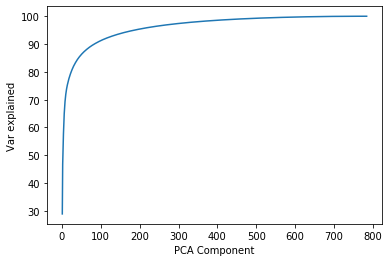

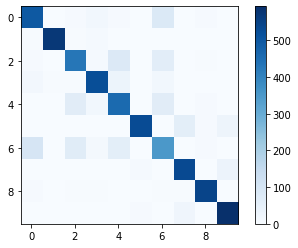

In [13]:
# run training with 80% of 30k (24k train and 6k test) - run time around 2mins
# this test accuracy appeared to have lower accuracy than the 30k train - 2k test
# due to the fact that we learned more with 30k

def run_training(x_train, y_train):
    data_set = concat_array(x_train, y_train)
    split_ratio = 0.80
    training_set, test_set = split_dataset(data_set, split_ratio)

    # Apply pca with training set using 50 components
    train, vectors = pca(training_set[:,0:-1], 50)
    print("pca train shape: ",train.shape)
    
    # projection of new data onto pca
    test = projection(test_set[:,0:-1], vectors)
    print("pca test shape: ",test.shape, "\n")
    
    train = concat_array(train, training_set[:,-1])
    test = concat_array(test, test_set[:,-1])
    
    start = time.time()
    predictions= predict(train, test)
    end = time.time()
    
    print(len(predictions))
    
    # get accuracy of the predictions
    accuracy = get_accuracy(test_set, predictions)
    print('Validation accuracy: ' + repr(accuracy), '%')
    print('Running duration: ' + repr(end - start), "seconds")
    
    label = np.asarray(predictions)
    print(label.shape)
    
    show_confusionmatrix_graph(calc_confusionmatrix(test_set, predictions))

run_training(
    data_train, 
    label_train
)

In [14]:
# assume output is the predicted labels
# (5000,) 
def output_result(output):
    with h5py.File('output/predicted_labels.h5','w') as H:
        H.create_dataset('output',data=output)

    print(output)

Cumulative variance captured at component number 50 is 86.40140010931123 %

pca train shape:  (30000, 50)
pca test shape:  (5000, 50) 

Number of nearest neighbors:  3
Training dataset... please wait... around 2mins...
.
.
.
Test accuracy on 2k test samples: 85.25%
Running duration: 135.17899680137634seconds
(5000,)
[1. 0. 9. ... 5. 0. 5.]


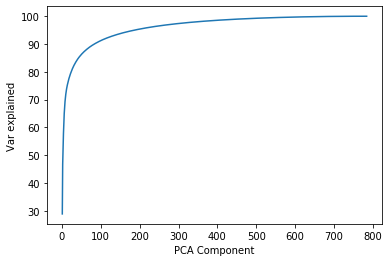

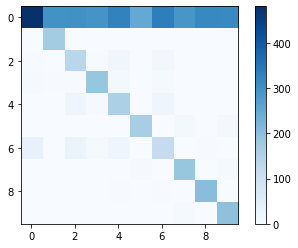

In [15]:
# run testing with 30k train and 2k test data set
def run_testing(x_train, y_train, x_test, y_test):
    # pca the 30k dataset using 50 components
    # train variables = the pca matrix output
    # vectors = eigen vectors of from the pca
    train, vectors = pca(x_train, 50)
    print("pca train shape: ",train.shape)
    
    # projection of 5k new data onto pca
    test = projection(x_test, vectors)
    print("pca test shape: ",test.shape, "\n")
    
    train = concat_array(train, y_train)
    # fill the label array with 0 for the 8k unlabeled samples
    test = concat_array(test, np.pad(y_test, (0, 3000), 'constant'))

    # Train 30k and make prediction on 10k test samples
    start = time.time()
    predictions = predict(train, test)
    end = time.time()
    
    # get accuracy of the 1st 2k test predictions
    accuracy = get_accuracy(test[0:2000], predictions[0:2000])
    print('Test accuracy on 2k test samples: ' + repr(accuracy) + '%')
    print('Running duration: ' + repr(end - start) + "seconds")
    
    
    label = np.asarray(predictions)
    print(label.shape)
    # output the predict array
    output_result(label)
    
    show_confusionmatrix_graph(calc_confusionmatrix(test, predictions))


run_testing(
    data_train, 
    label_train, 
    data_test[0:5000], 
    label_test[0:5000]
)

In [16]:
# cross check the output file

# Open and read the printed output
with h5py.File('./output/predicted_labels.h5','r') as H:
    test_result_label = np.copy(H['output'])
    
print(test_result_label.shape)
print(test_result_label)

(5000,)
[1. 0. 9. ... 5. 0. 5.]


## The end